# Compare Result

this notebook created for comparing result between predicted result from ML model and truth set 

In [1]:
!pip install venn

# BAT

In [2]:
from venn import venn
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

from functools import reduce

In [3]:
columns = ["ID_Query","ID_Target","sequence_identity","alignment_length","number_of_mismatches","number_of_gap_openings", "start-position_in_query", "end-position_in_query", "start-position_in_target","end-position_in_target","E-value","bit_score"]

In [3]:
def plot_ven_AMP_NonAMP(sample_test,sample_groundtruth,prediced_set,truth_set):
    Samples = {
        sample_test:  set(prediced_set["ID"]),
        sample_groundtruth: set(truth_set['ID_Query']),
        }
    venn(Samples)
    venn(Samples, fmt="{percentage:.2f}%")    
    
def accuracy_cal( predict , total_AMPs):
    accuracy = (predict/total_AMPs )*100
    print(" Accuracy Percentage = %.2f" % accuracy)

# ---------------------------------------

From A)  first we use prediction result ( which contains both NonAMP  and AMP  )  ( Purple bubble here )  intersect with a ground truth set.

Next , In B) we exclude the non AMPs out from prediction results , we see a high number in ( purple bubble). This means  Most of the sequence predict to be AMP rather than to be a non AMP (you  can see the  number  in purple part between A and B) which is not likely to be  true . So in this case show a Very high false positive rate on the prediction (i.e., predict Non AMP to be AMP , high amount in purple color in Venn diagram),  
(If we calculate non amp  625K-579K = 46K.)

Next if we look into yellow bubble , there is a remaining  number  in yellow which we consider it as a false negative  because the model predict these  as the Non AMPs.

## Version 2 , FastAI

In [48]:
Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_FastAI/Bat.len10.MLResult.plk")
Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output/BAT.alnRes.m8.len10.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

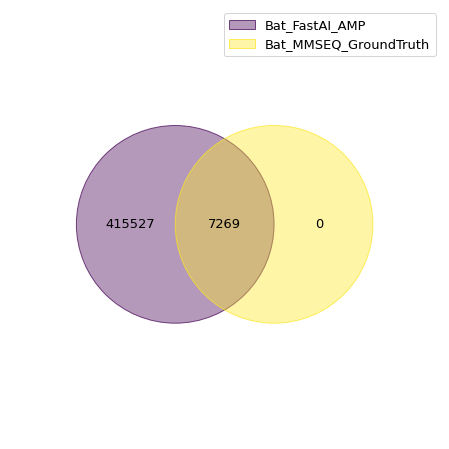

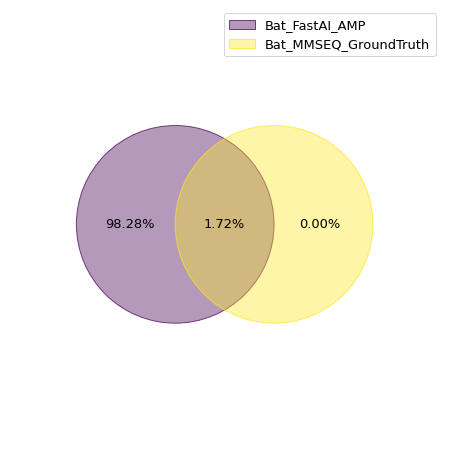

In [49]:
# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_FastAI_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )

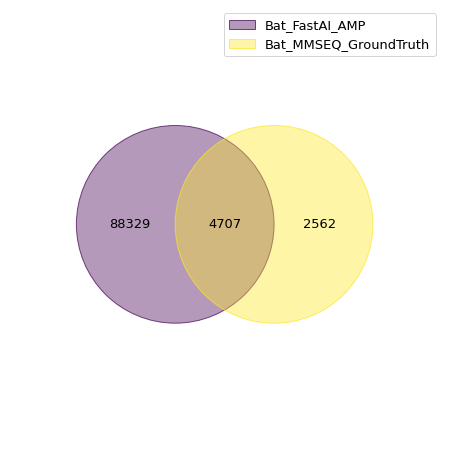

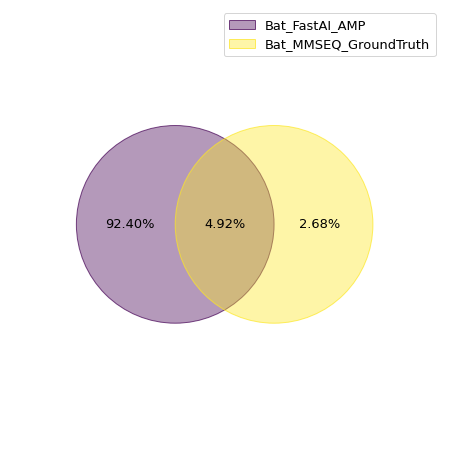

In [50]:
# AMP only compares with ground truth
plot_ven_AMP_NonAMP("Bat_FastAI_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )

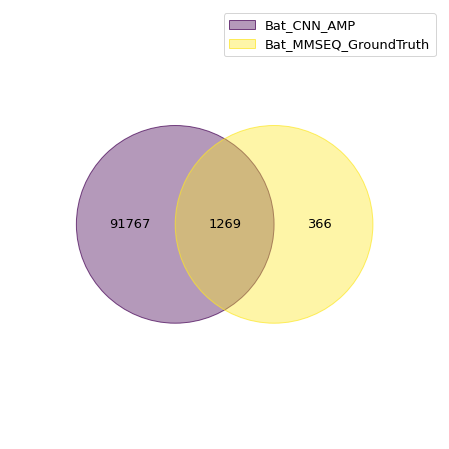

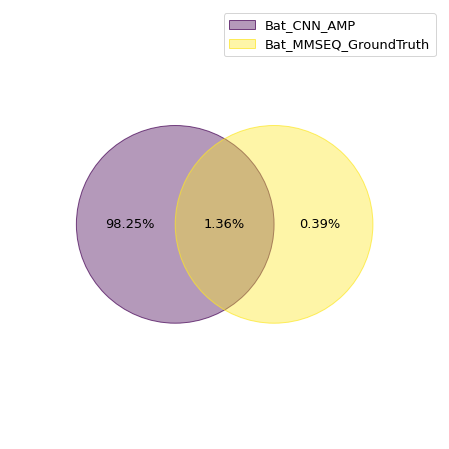

In [51]:
# AMP only compares with filtering 100% seq identity on ground truth
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [58]:
# total 
accuracy = (4707/Bat_total_AMPS )*100
accuracy_100 = (1269/filtered_BAT_total_AMPS_with100 )*100
print("acurracy: %.2f" % accuracy)
print("acurracy Filtered 100 : %.2f" % accuracy_100)

acurracy: 64.75
acurracy Filtered 100 : 77.61


## with length <= 200

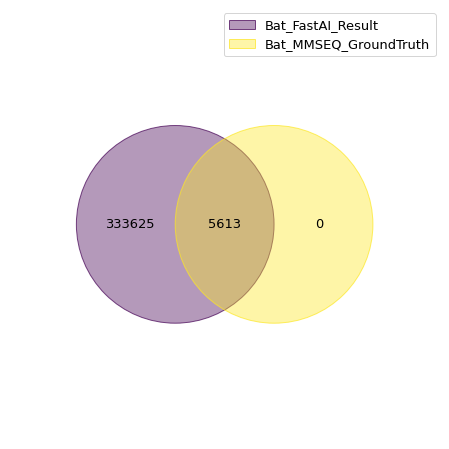

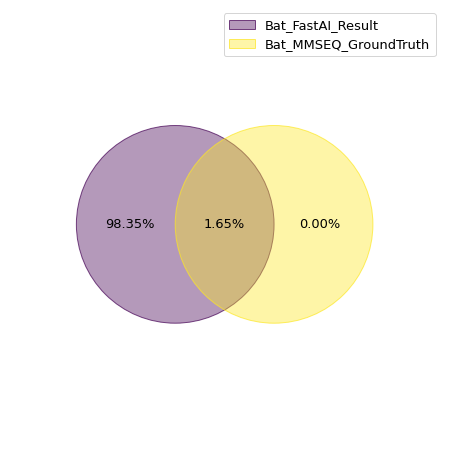

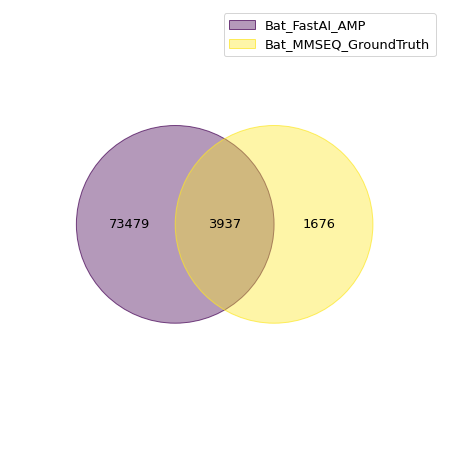

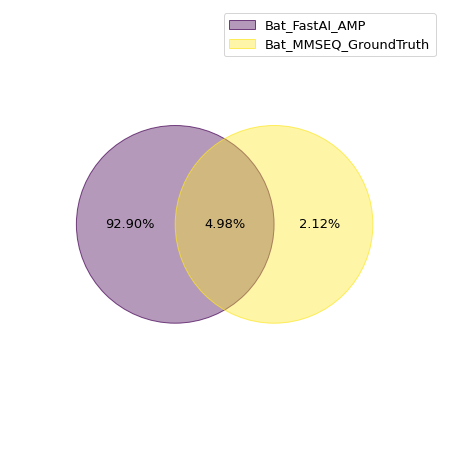

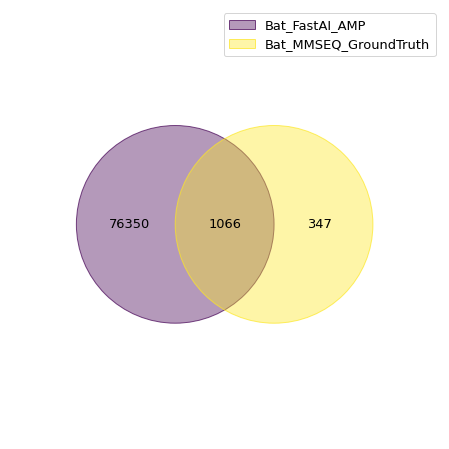

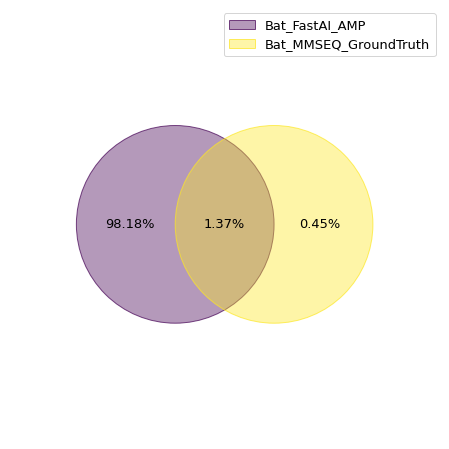

In [81]:
## with length <= 200

Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_FastAI/Bat.len10.MLResult.plk")
Bat_ML = Bat_ML[Bat_ML["length"]<= 200]

Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output200/bat.len200.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_FastAI_Result","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )
# AMP only compares with ground truth
plot_ven_AMP_NonAMP("Bat_FastAI_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_FastAI_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [82]:

# total 
accuracy = (3937/Bat_total_AMPS )*100
accuracy_100 = (1066/filtered_BAT_total_AMPS_with100 )*100
print("acurracy: %.2f" % accuracy)
print("acurracy Filtered : %.2f" % accuracy_100)

acurracy: 70.14
acurracy Filtered : 75.44



## with length <= 30 (No ouput from MMseq)

In [ ]:

## with length <= 30


Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_FastAI/Bat.len10.MLResult.plk")
Bat_ML = Bat_ML[Bat_ML["length"]<= 30]

Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output200/bat.len200.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_FastAI_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )
# AMP only compares with ground truth
plot_ven_AMP_NonAMP("Bat_FastAI_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )



In [ ]:
# total 
accuracy_cal(267, DECockroach_truth_total_30 )
# 100% similarity 
accuracy_cal(41, DECockroach_total_30_with100 )

## Version 2 , CNN

In [85]:
Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_CNN/Bat.len10.MLResult.plk")
Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output/BAT.alnRes.m8.len10.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

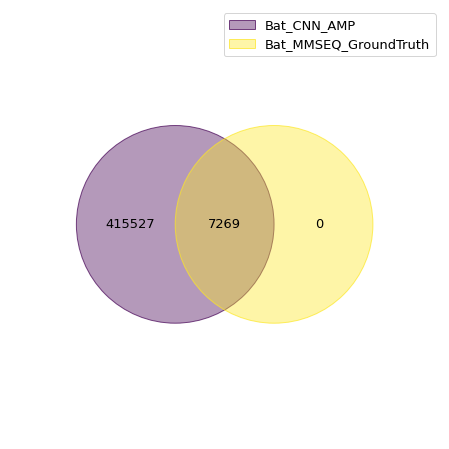

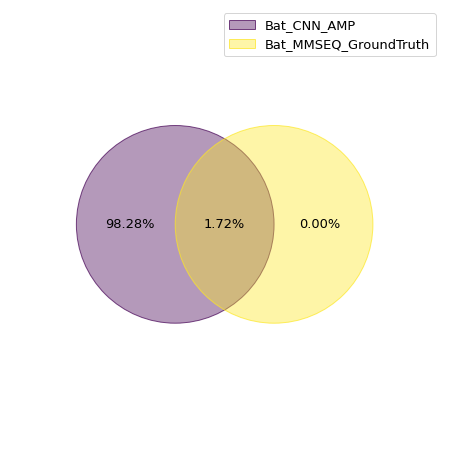

In [86]:
# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )

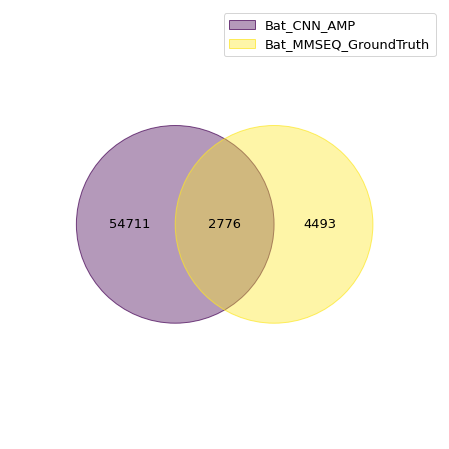

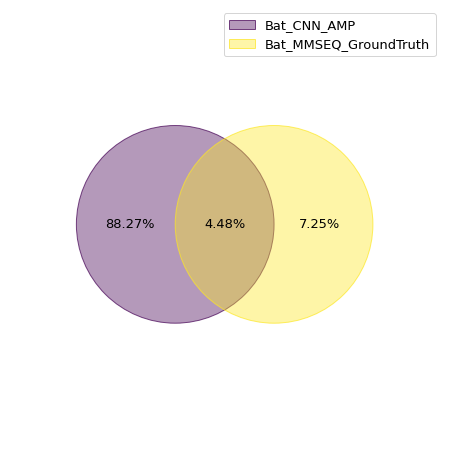

In [88]:


plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )

For sequence identiy s equal to 100%

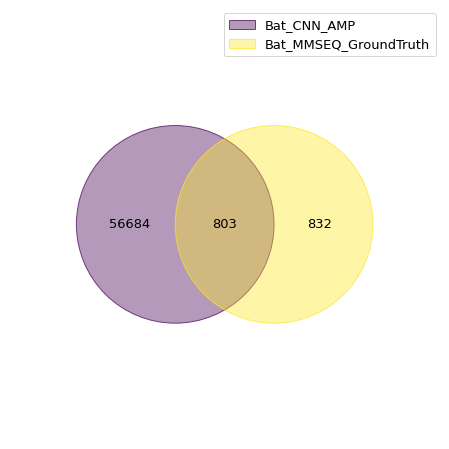

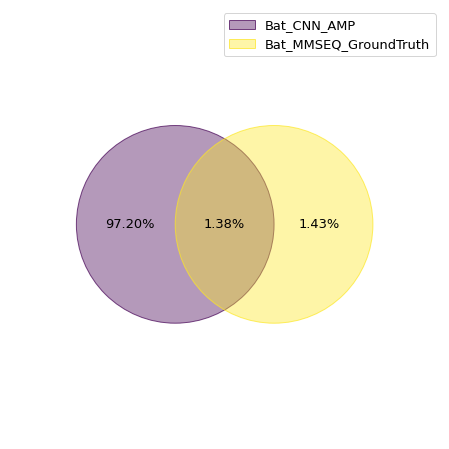

In [89]:
### 100% identity
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [90]:
accuracy = (2766/Bat_total_AMPS )*100
accuracy_100 = (803/filtered_BAT_total_AMPS_with100 )*100
print("Baseline: %.2f" % accuracy)
print("Filtered: %.2f" % accuracy_100)

Baseline: 38.05
Filtered: 49.11


## with length <= 200

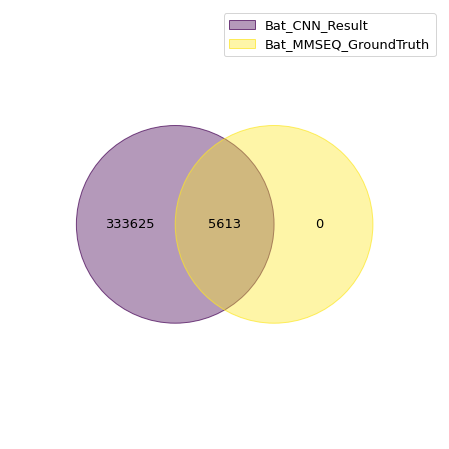

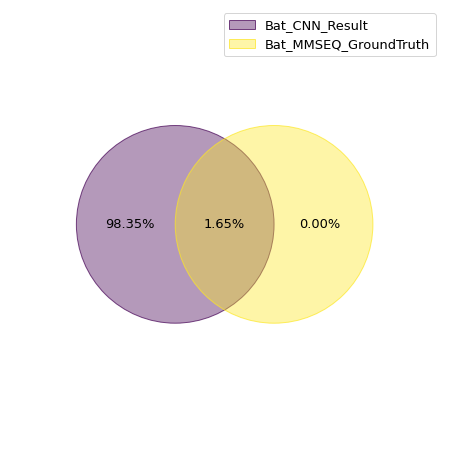

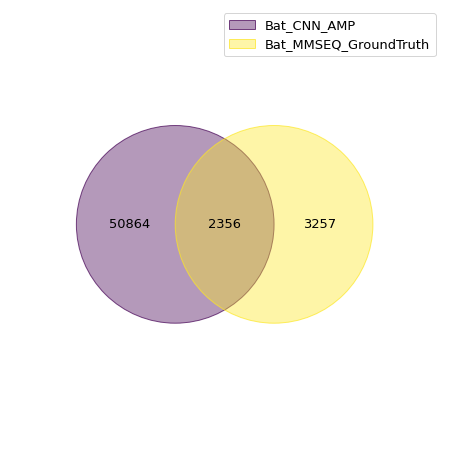

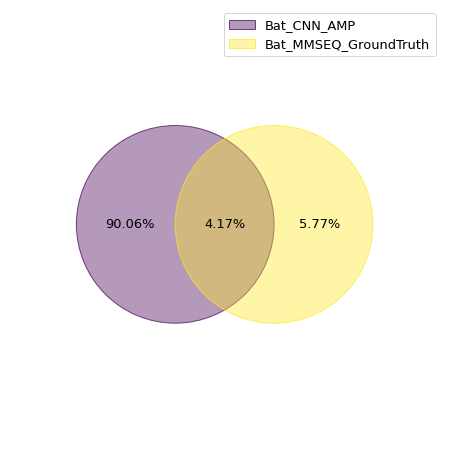

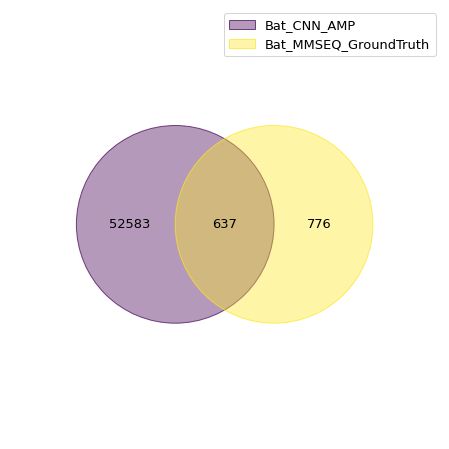

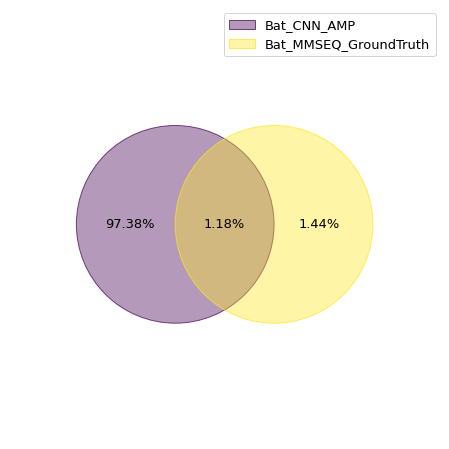

In [8]:

Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_CNN_RMSpop/Bat.len10.MLResult.plk")
Bat_ML = Bat_ML[Bat_ML["length"]<= 200]

Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output200/bat.len200.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_CNN_Result","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )
# AMP only compares with ground truth
plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [92]:

# total 
accuracy = (2536/Bat_total_AMPS )*100
accuracy_100 = (637/filtered_BAT_total_AMPS_with100 )*100
print("acurracy: %.2f" % accuracy)
print("acurracy Filtered : %.2f" % accuracy_100)

acurracy: 45.18
acurracy Filtered : 45.08


## with length <= 30 (No ouput from MMseq)

# Ensemble 

In [4]:
Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_Ensemble/Bat.len10.MLResult.plk")
Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output/BAT.alnRes.m8.len10.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

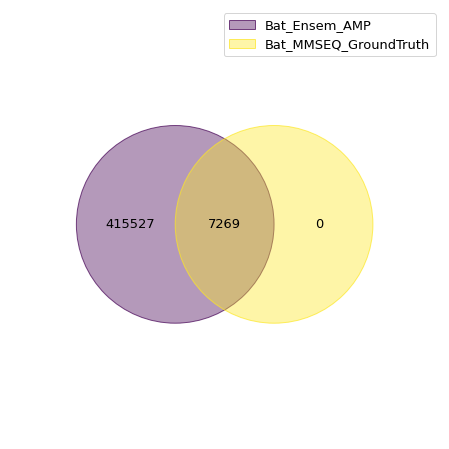

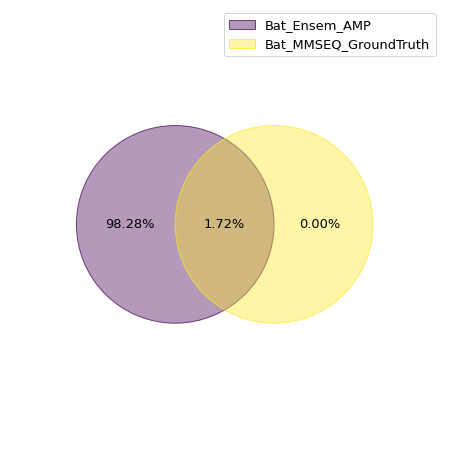

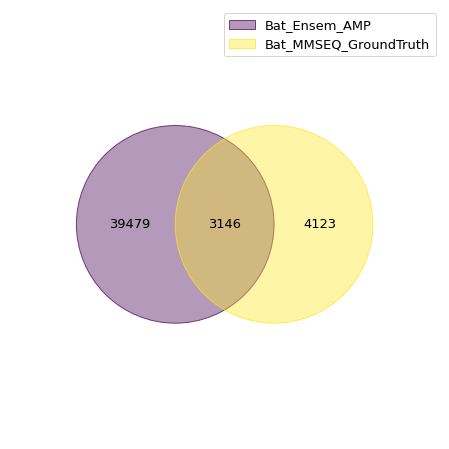

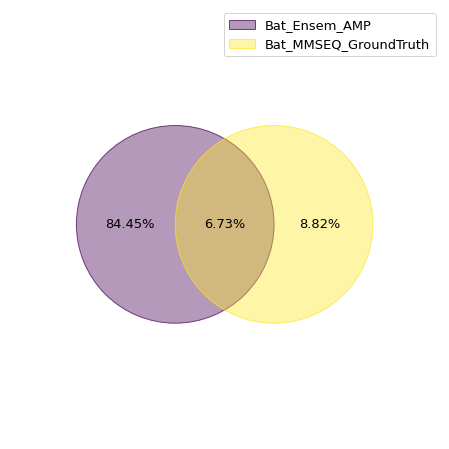

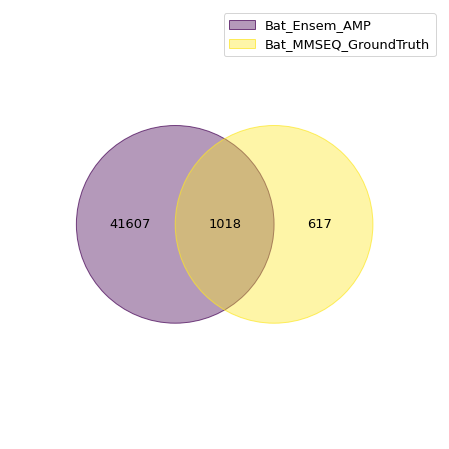

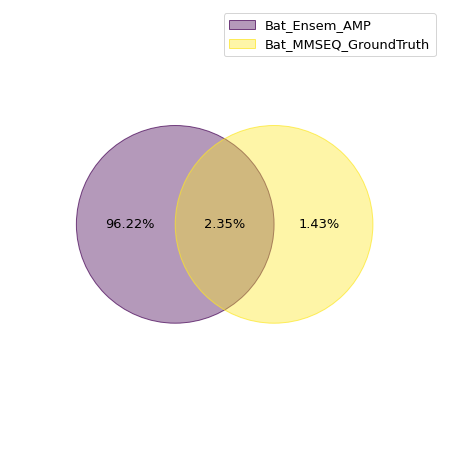

In [5]:
# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_Ensem_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )

plot_ven_AMP_NonAMP("Bat_Ensem_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )

### 100% identity
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_Ensem_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [6]:
accuracy = (3146/Bat_total_AMPS )*100
accuracy_100 = (1018/filtered_BAT_total_AMPS_with100 )*100
print("Baseline: %.2f" % accuracy)
print("Filtered: %.2f" % accuracy_100)

Baseline: 43.28
Filtered: 62.26


## with length <= 200

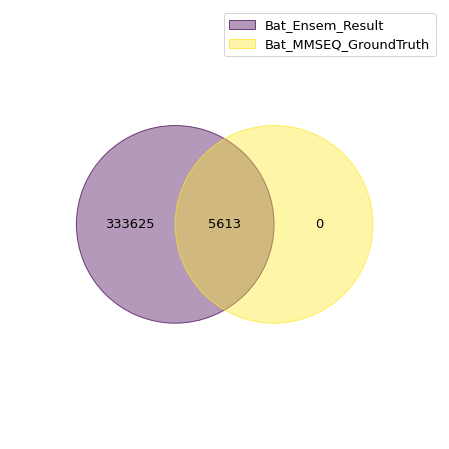

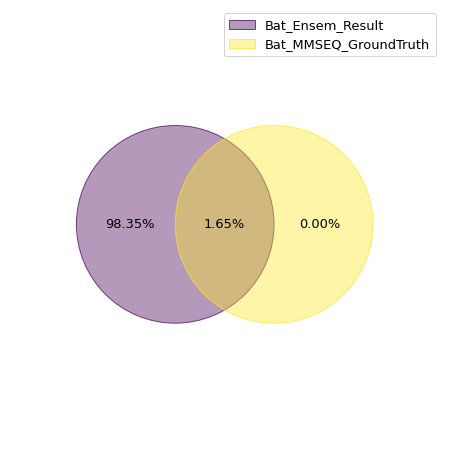

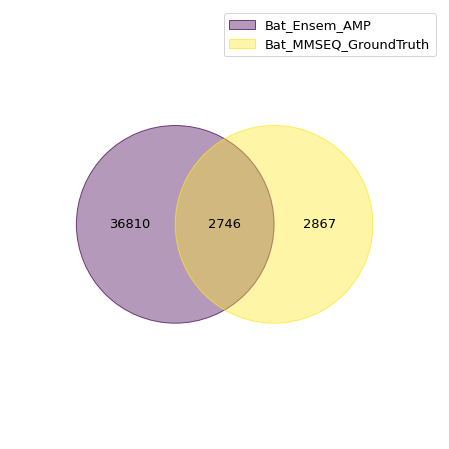

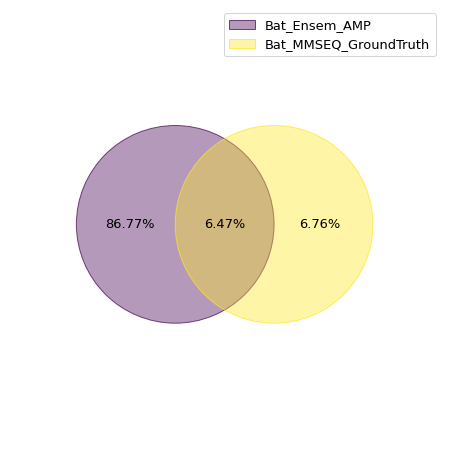

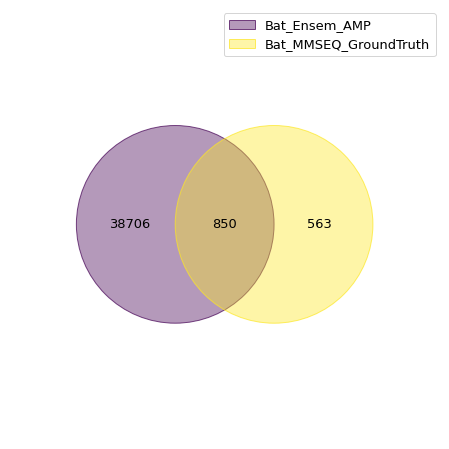

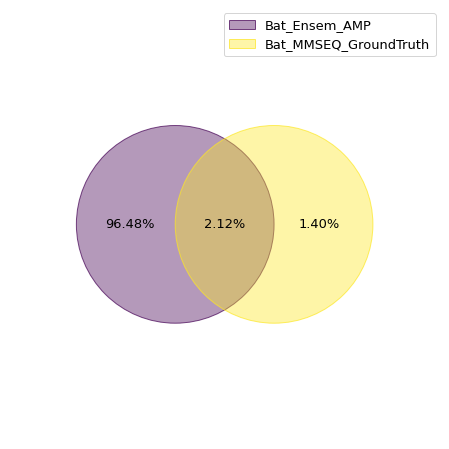

In [9]:

Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_Ensemble/Bat.len10.MLResult.plk")
Bat_ML = Bat_ML[Bat_ML["length"]<= 200]

Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output200/bat.len200.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_Ensem_Result","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )
# AMP only compares with ground truth
plot_ven_AMP_NonAMP("Bat_Ensem_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_Ensem_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [11]:
# total 
accuracy = (2746/Bat_total_AMPS )*100
accuracy_100 = (850/filtered_BAT_total_AMPS_with100 )*100
print("acurracy: %.2f" % accuracy)
print("acurracy Filtered : %.2f" % accuracy_100)

acurracy: 48.92
acurracy Filtered : 60.16
